# Data preparation

In [16]:
# Based on the codes in the Eduardo's code as well as the code in the Spotipy documentation https://spotipy.readthedocs.io/en/2.22.1/

# import dependencies
import spotipy as sp
from spotipy.oauth2 import SpotifyClientCredentials
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Authorisation
from config import CLIENT_ID
from config import CLIENT_SECRET

# Initialize the Spotify client with client credentials flow
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = sp.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
# Changed a couple of the links, so we have consistent data. 
# We had top TRACKS playlist for a couple of years (len = 50) but top HITS for the other years (len = 100), 
# so I've made it consistent
Years = {"2017": "https://open.spotify.com/playlist/37i9dQZF1DWTE7dVUebpUW",
        "2018": "https://open.spotify.com/playlist/37i9dQZF1DXe2bobNYDtW8",
        "2019": "https://open.spotify.com/playlist/37i9dQZF1DWVRSukIED0e9",
        "2020": "https://open.spotify.com/playlist/2fmTTbBkXi8pewbUvG3CeZ",
        "2021": "https://open.spotify.com/playlist/5GhQiRkGuqzpWZSE7OU4Se",
        "2022": "https://open.spotify.com/playlist/56r5qRUv3jSxADdmBkhcz7"}

# set empty lists to add data to
track_features = []
track_id = []
track_name = []
track_popularity = []
artist_name = []
artist_id = []
artist_genre = []

# loop through years to request data we need for each year
for year in Years:
    playlist_URI = Years[year]
    
    # apend gave me a list of lists, so using extend instead    
    # get tracks for this year
    track_id_this_year = [x["track"]["id"] for x in sp.playlist_tracks(playlist_URI)["items"]]
   
    # get track features
    track_features.extend(sp.audio_features(track_id_this_year))    
    
    #get the rest of tracks info
    track_id.extend(track_id_this_year)
    track_name.extend ([x["track"]["name"] for x in sp.playlist_tracks(playlist_URI)["items"]])
    track_popularity.extend ([x["track"]["popularity"] for x in sp.playlist_tracks(playlist_URI)["items"]])
    
    # get artist info
    artist_name.extend([x["track"]["artists"][0]["name"] for x in sp.playlist_tracks(playlist_URI)["items"]])
    artist_id.extend([x["track"]["artists"][0]["id"] for x in sp.playlist_tracks(playlist_URI)["items"]])
    
    # get artist uri so we can get genre
    artist_uri = [x["track"]["artists"][0]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]
    artist_genre.extend([sp.artist(uri)["genres"] for uri in artist_uri])
    

In [6]:
# join all the information in a dataframe

# first the track info
years = ['2017', '2018', '2019', '2020', '2021', '2022']
year_index = np.repeat(years,100)

track_info = pd.DataFrame({"Year": year_index,
                           "id" : track_id,
                           "artist id" : artist_id,
                           "track name" : track_name,
                           "artist name" : artist_name,
                           "artist genre": artist_genre,
                           "track popularity" : track_popularity})

# then the track features
track_features_df = pd.DataFrame(track_features)

# and now merge the two
complete_df = pd.merge(track_info, track_features_df, on = "id", how = "inner")

# the merged df has 44 duplicates, so getting rid of them here. We end up with a df with len = 600 (100 songs for each year)
complete_df = complete_df.drop_duplicates(["id", "Year"])

# save output
complete_df.to_csv('output_data/spotipy_data.csv')
complete_df

,Year,id,artist id,track name,artist name,artist genre,track popularity,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,2017,7qiZfU4dY1lWllzX7mPBI3,6eUKZXaKkcviH0Ku9w2n3V,Shape of You,Ed Sheeran,"[pop, singer-songwriter pop, uk pop]",88,0.825,0.652,1,...,0.00000,0.0931,0.931,95.977,audio_features,spotify:track:7qiZfU4dY1lWllzX7mPBI3,https://api.spotify.com/v1/tracks/7qiZfU4dY1lW...,https://api.spotify.com/v1/audio-analysis/7qiZ...,233713,4
1,2017,0pqnGHJpmpxLKifKRmU6WP,53XhwfbYqKCa1cC15pYq2q,Believer,Imagine Dragons,"[modern rock, pop, rock]",89,0.776,0.780,10,...,0.00000,0.0810,0.666,124.949,audio_features,spotify:track:0pqnGHJpmpxLKifKRmU6WP,https://api.spotify.com/v1/tracks/0pqnGHJpmpxL...,https://api.spotify.com/v1/audio-analysis/0pqn...,204347,4
2,2017,6habFhsOp2NvshLv26DqMb,4V8Sr092TqfHkfAA5fXXqG,Despacito,Luis Fonsi,"[latin pop, puerto rican pop]",81,0.655,0.797,2,...,0.00000,0.0670,0.839,177.928,audio_features,spotify:track:6habFhsOp2NvshLv26DqMb,https://api.spotify.com/v1/tracks/6habFhsOp2Nv...,https://api.spotify.com/v1/audio-analysis/6hab...,229360,4
3,2017,1PSBzsahR2AKwLJgx8ehBj,6TIYQ3jFPwQSRmorSezPxX,Bad Things (with Camila Cabello),Machine Gun Kelly,"[ohio hip hop, pop rap]",73,0.697,0.691,2,...,0.00000,0.1850,0.305,137.853,audio_features,spotify:track:1PSBzsahR2AKwLJgx8ehBj,https://api.spotify.com/v1/tracks/1PSBzsahR2AK...,https://api.spotify.com/v1/audio-analysis/1PSB...,239293,4
4,2017,5knuzwU65gJK7IF5yJsuaW,6MDME20pz9RveH9rEXvrOM,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,"[pop, uk dance, uk funky]",76,0.720,0.763,9,...,0.00000,0.1800,0.742,101.965,audio_features,spotify:track:5knuzwU65gJK7IF5yJsuaW,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,https://api.spotify.com/v1/audio-analysis/5knu...,251088,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,2022,2g6tReTlM2Akp41g0HaeXN,2YZyLoL8N0Wb9xBt1NhZWg,Die Hard,Kendrick Lamar,"[conscious hip hop, hip hop, rap, west coast rap]",78,0.775,0.736,1,...,0.00116,0.1270,0.362,100.988,audio_features,spotify:track:2g6tReTlM2Akp41g0HaeXN,https://api.spotify.com/v1/tracks/2g6tReTlM2Ak...,https://api.spotify.com/v1/audio-analysis/2g6t...,239027,4
640,2022,4pi1G1x8tl9VfdD9bL3maT,3MdXrJWsbVzdn6fe5JYkSQ,Big Energy,Latto,[trap queen],67,0.937,0.793,11,...,0.00000,0.3410,0.794,106.022,audio_features,spotify:track:4pi1G1x8tl9VfdD9bL3maT,https://api.spotify.com/v1/tracks/4pi1G1x8tl9V...,https://api.spotify.com/v1/audio-analysis/4pi1...,172540,4
641,2022,3LtpKP5abr2qqjunvjlX5i,5H4yInM5zmHqpKIoMNAx4r,Doja,Central Cee,[melodic drill],84,0.911,0.573,6,...,0.00000,0.4030,0.972,140.040,audio_features,spotify:track:3LtpKP5abr2qqjunvjlX5i,https://api.spotify.com/v1/tracks/3LtpKP5abr2q...,https://api.spotify.com/v1/audio-analysis/3Ltp...,97393,4
642,2022,3XOalgusokruzA5ZBA2Qcb,2hlmm7s2ICUX0LVIhVFlZQ,pushin P (feat. Young Thug),Gunna,"[atl hip hop, melodic rap, rap, trap]",75,0.773,0.422,1,...,0.00693,0.1290,0.488,77.502,audio_features,spotify:track:3XOalgusokruzA5ZBA2Qcb,https://api.spotify.com/v1/tracks/3XOalgusokru...,https://api.spotify.com/v1/audio-analysis/3XOa...,136267,1


In [29]:
pop_artist = complete_df.loc[(complete_df["artist name"] == 'Drake'), :]
pop_artist

,Year,id,artist id,track name,artist name,artist genre,track popularity,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
19,2017,5mCPDVBb16L4XQwDdbRUpz,3TVXtAsR1Inumwj472S9r4,Passionfruit,Drake,"[canadian hip hop, canadian pop, hip hop, pop ...",86,0.809,0.463,11,...,0.085000,0.1090,0.3640,111.980,audio_features,spotify:track:5mCPDVBb16L4XQwDdbRUpz,https://api.spotify.com/v1/tracks/5mCPDVBb16L4...,https://api.spotify.com/v1/audio-analysis/5mCP...,298941,4
91,2017,343YBumqHu19cGoGARUTsd,3TVXtAsR1Inumwj472S9r4,Fake Love,Drake,"[canadian hip hop, canadian pop, hip hop, pop ...",75,0.928,0.481,9,...,0.000000,0.1760,0.6130,134.007,audio_features,spotify:track:343YBumqHu19cGoGARUTsd,https://api.spotify.com/v1/tracks/343YBumqHu19...,https://api.spotify.com/v1/audio-analysis/343Y...,210937,4
120,2018,6DCZcSspjsKoFjzjrWoCdn,3TVXtAsR1Inumwj472S9r4,God's Plan,Drake,"[canadian hip hop, canadian pop, hip hop, pop ...",86,0.754,0.449,7,...,0.000083,0.5520,0.3570,77.169,audio_features,spotify:track:6DCZcSspjsKoFjzjrWoCdn,https://api.spotify.com/v1/tracks/6DCZcSspjsKo...,https://api.spotify.com/v1/audio-analysis/6DCZ...,198973,4
145,2018,3CA9pLiwRIGtUBiMjbZmRw,3TVXtAsR1Inumwj472S9r4,Nice For What,Drake,"[canadian hip hop, canadian pop, hip hop, pop ...",81,0.585,0.909,8,...,0.000097,0.1190,0.7580,93.372,audio_features,spotify:track:3CA9pLiwRIGtUBiMjbZmRw,https://api.spotify.com/v1/tracks/3CA9pLiwRIGt...,https://api.spotify.com/v1/audio-analysis/3CA9...,210747,4
152,2018,0TlLq3lA83rQOYtrqBqSct,3TVXtAsR1Inumwj472S9r4,Nonstop,Drake,"[canadian hip hop, canadian pop, hip hop, pop ...",81,0.912,0.412,7,...,0.012600,0.1040,0.4230,154.983,audio_features,spotify:track:0TlLq3lA83rQOYtrqBqSct,https://api.spotify.com/v1/tracks/0TlLq3lA83rQ...,https://api.spotify.com/v1/audio-analysis/0TlL...,238614,4
165,2018,2G7V7zsVDxg1yRsu7Ew9RJ,3TVXtAsR1Inumwj472S9r4,In My Feelings,Drake,"[canadian hip hop, canadian pop, hip hop, pop ...",77,0.835,0.626,1,...,0.000060,0.3960,0.3500,91.030,audio_features,spotify:track:2G7V7zsVDxg1yRsu7Ew9RJ,https://api.spotify.com/v1/tracks/2G7V7zsVDxg1...,https://api.spotify.com/v1/audio-analysis/2G7V...,217925,4
211,2018,3qN5qMTKyEEmiTZD38BNTT,3TVXtAsR1Inumwj472S9r4,I'm Upset,Drake,"[canadian hip hop, canadian pop, hip hop, pop ...",69,0.899,0.586,11,...,0.000000,0.0836,0.4920,150.002,audio_features,spotify:track:3qN5qMTKyEEmiTZD38BNTT,https://api.spotify.com/v1/tracks/3qN5qMTKyEEm...,https://api.spotify.com/v1/audio-analysis/3qN5...,214467,4
268,2019,5ry2OE6R2zPQFDO85XkgRb,3TVXtAsR1Inumwj472S9r4,Money In The Grave (Drake ft. Rick Ross),Drake,"[canadian hip hop, canadian pop, hip hop, pop ...",79,0.831,0.502,10,...,0.000000,0.1220,0.1010,100.541,audio_features,spotify:track:5ry2OE6R2zPQFDO85XkgRb,https://api.spotify.com/v1/tracks/5ry2OE6R2zPQ...,https://api.spotify.com/v1/audio-analysis/5ry2...,205427,4
344,2020,127QTOFJsJQp5LbJbu3A1y,3TVXtAsR1Inumwj472S9r4,Toosie Slide,Drake,"[canadian hip hop, canadian pop, hip hop, pop ...",74,0.834,0.454,1,...,0.000006,0.1140,0.8370,81.618,audio_features,spotify:track:127QTOFJsJQp5LbJbu3A1y,https://api.spotify.com/v1/tracks/127QTOFJsJQp...,https://api.spotify.com/v1/audio-analysis/127Q...,247059,4
368,2020,2SAqBLGA283SUiwJ3xOUVI,3TVXtAsR1Inumwj472S9r4,Laugh Now Cry Later (feat. Lil Durk),Drake,"[canadian hip hop, canadian pop, hip hop, pop ...",80,0.761,0.518,0,...,0.000035,0.1070,0.5220,133.976,audio_features,spotify:track:2SAqBLGA283SUiwJ3xOUVI,https://api.spotify.com/v1/tracks/2SAqBLGA283S...,https://api.spotify.com/v1/audio-analysis/2SAq...,261493,4


<function matplotlib.pyplot.show(close=None, block=None)>

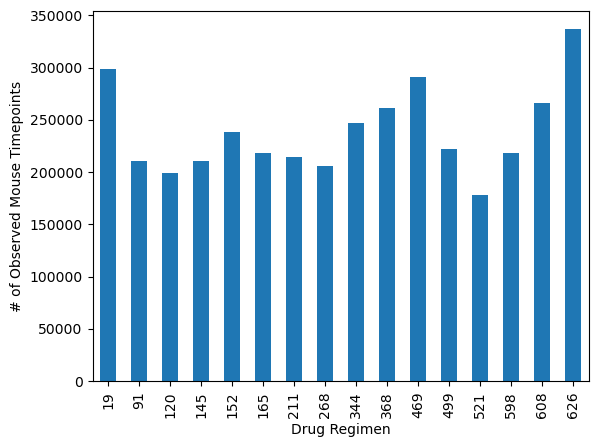

In [32]:
# drake_x = pop_artist["Year"]
# drake_y = pop_artist["duration_ms"]
# plt.plot(drake_x, drake_y)
# plt.title("Average Drake Over Time")
# plt.xlabel("Years")
# plt.ylabel("Drake")
# #plt.savefig("output_data/avg_dance.png")

ttp = pop_artist["duration_ms"]
ttp.plot(kind = "bar")
plt.xlabel("Drug Regimen")
plt.ylabel("# of Observed Mouse Timepoints")
plt.show

In [9]:
# Summary statistics table for Danceability 
dance_mean = complete_df.groupby("Year")["danceability"].mean()
dance_median = complete_df.groupby("Year")["danceability"].median()
dance_variance = complete_df.groupby("Year")["danceability"].var()
dance_std = complete_df.groupby("Year")["danceability"].std()
dance_sem = complete_df.groupby("Year")["danceability"].sem()

# Assembling the resulting series into a DataFrame
dance_df = pd.DataFrame({"Mean Danceability": dance_mean, 
                         "Median Danceability": dance_median, 
                         "Danceability Variance": dance_variance, 
                         "Danceability Std Dev": dance_std, 
                         "Danceability Std Error": dance_sem})
dance_df.index.name = "Year"
dance_df

,Mean Danceability,Median Danceability,Danceability Variance,Danceability Std Dev,Danceability Std Error
Year,,,,,
2017,0.69548,0.7115,0.017488,0.132240,0.013224
2018,0.70376,0.7015,0.017013,0.130434,0.013043
2019,0.71095,0.7365,0.018476,0.135928,0.013593
2020,0.70335,0.7195,0.015395,0.124076,0.012408
2021,0.69239,0.7135,0.017592,0.132634,0.013263
2022,0.66973,0.6870,0.024480,0.156460,0.015646


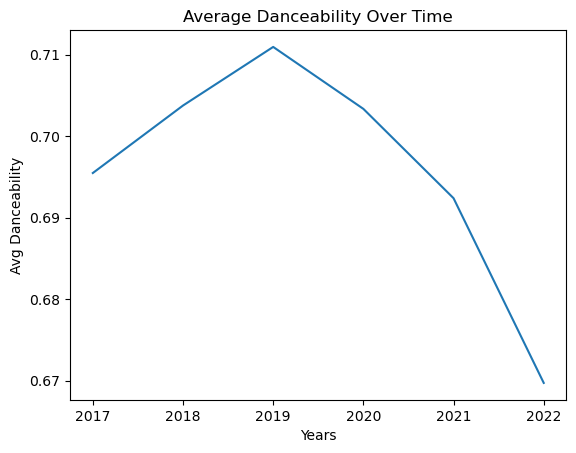

In [23]:
dance_avg_x = dance_df.index
dance_avg_y = dance_df["Mean Danceability"]
plt.plot(dance_avg_x, dance_avg_y)
plt.title("Average Danceability Over Time")
plt.xlabel("Years")
plt.ylabel("Avg Danceability")
plt.savefig("output_data/avg_dance.png")

In [10]:
# Summary statistics table for Energy 
energy_mean = complete_df.groupby("Year")["energy"].mean()
energy_median = complete_df.groupby("Year")["energy"].median()
energy_variance = complete_df.groupby("Year")["energy"].var()
energy_std = complete_df.groupby("Year")["energy"].std()
energy_sem = complete_df.groupby("Year")["energy"].sem()

# Assembling the resulting series into a DataFrame
energy_df = pd.DataFrame({"Mean Energy": energy_mean, 
                          "Median Energy": energy_median, 
                          "Energy Variance": energy_variance, 
                          "Energy Std Dev": energy_std, 
                          "Energy Std Error": energy_sem})
energy_df.index.name = "Year"
energy_df

,Mean Energy,Median Energy,Energy Variance,Energy Std Dev,Energy Std Error
Year,,,,,
2017,0.63109,0.6525,0.025006,0.158134,0.015813
2018,0.66027,0.6760,0.019827,0.140807,0.014081
2019,0.61981,0.6275,0.026349,0.162323,0.016232
2020,0.61426,0.6270,0.024518,0.156581,0.015658
2021,0.61450,0.6175,0.021417,0.146345,0.014634
2022,0.63938,0.6720,0.026814,0.163749,0.016375


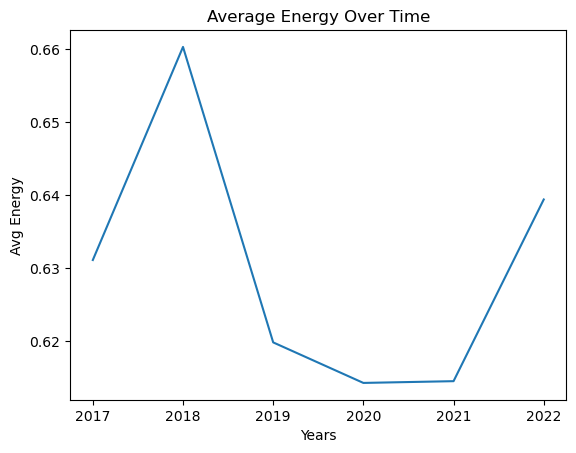

In [26]:
energy_avg_x = energy_df.index
energy_avg_y = energy_df["Mean Energy"]
plt.plot(energy_avg_x, energy_avg_y)
plt.title("Average Energy Over Time")
plt.xlabel("Years")
plt.ylabel("Avg Energy")
plt.savefig("output_data/avg_energy.png")

In [11]:
# Summary statistics table for Liveness 
live_mean = complete_df.groupby("Year")["liveness"].mean()
live_median = complete_df.groupby("Year")["liveness"].median()
live_variance = complete_df.groupby("Year")["liveness"].var()
live_std = complete_df.groupby("Year")["liveness"].std()
live_sem = complete_df.groupby("Year")["liveness"].sem()

# Assembling the resulting series into a DataFrame
live_df = pd.DataFrame({"Mean Liveness": live_mean, 
                        "Median Liveness": live_median, 
                        "Liveness Variance": live_variance, 
                        "Liveness Std Dev": live_std, 
                        "Liveness Std Error": live_sem})
live_df.index.name = "Year"
live_df

,Mean Liveness,Median Liveness,Liveness Variance,Liveness Std Dev,Liveness Std Error
Year,,,,,
2017,0.154736,0.1225,0.009066,0.095217,0.009522
2018,0.165453,0.1195,0.015924,0.126190,0.012619
2019,0.152862,0.1110,0.012987,0.113959,0.011396
2020,0.173261,0.1135,0.020173,0.142032,0.014203
2021,0.162127,0.1215,0.012865,0.113424,0.011342
2022,0.171964,0.1180,0.014170,0.119036,0.011904


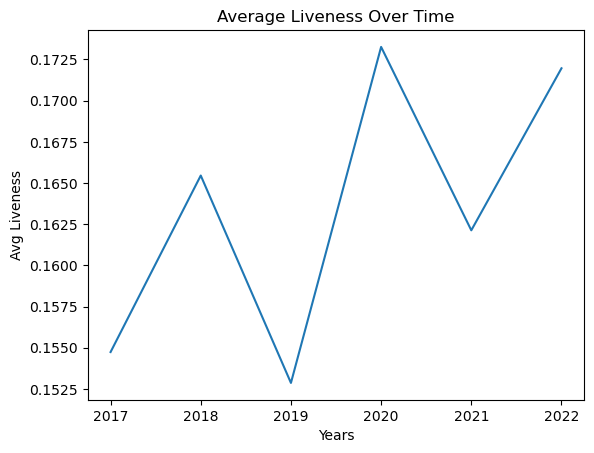

In [27]:
live_avg_x = live_df.index
live_avg_y = live_df["Mean Liveness"]
plt.plot(live_avg_x, live_avg_y)
plt.title("Average Liveness Over Time")
plt.xlabel("Years")
plt.ylabel("Avg Liveness")
plt.savefig("output_data/avg_live.png")

In [12]:
# Summary statistics table for Valence 
vale_mean = complete_df.groupby("Year")["valence"].mean()
vale_median = complete_df.groupby("Year")["valence"].median()
vale_variance = complete_df.groupby("Year")["valence"].var()
vale_std = complete_df.groupby("Year")["valence"].std()
vale_sem = complete_df.groupby("Year")["valence"].sem()

# Assembling the resulting series into a DataFrame
vale_df = pd.DataFrame({"Mean Valence": vale_mean, 
                        "Median Valence": vale_median, 
                        "Valence Variance": vale_variance, 
                        "Valence Std Dev": vale_std, 
                        "Valence Std Error": vale_sem})
vale_df.index.name = "Year"
vale_df

,Mean Valence,Median Valence,Valence Variance,Valence Std Dev,Valence Std Error
Year,,,,,
2017,0.464541,0.4400,0.050401,0.224501,0.022450
2018,0.467752,0.4615,0.042860,0.207028,0.020703
2019,0.482704,0.4930,0.050471,0.224658,0.022466
2020,0.510914,0.5150,0.050113,0.223860,0.022386
2021,0.488950,0.4760,0.054191,0.232789,0.023279
2022,0.515557,0.5180,0.069016,0.262708,0.026271


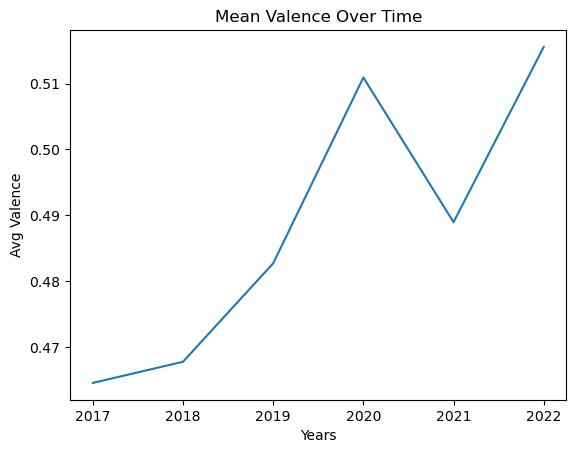

In [28]:
vale_avg_x = vale_df.index
vale_avg_y = vale_df["Mean Valence"]
plt.plot(vale_avg_x, vale_avg_y)
plt.title("Mean Valence Over Time")
plt.xlabel("Years")
plt.ylabel("Avg Valence")
plt.savefig("output_data/avg_vale.png")

In [13]:
# Summary statistics table for Tempo 
tempo_mean = complete_df.groupby("Year")["tempo"].mean()
tempo_median = complete_df.groupby("Year")["tempo"].median()
tempo_variance = complete_df.groupby("Year")["tempo"].var()
tempo_std = complete_df.groupby("Year")["tempo"].std()
tempo_sem = complete_df.groupby("Year")["tempo"].sem()

# Assembling the resulting series into a DataFrame
tempo_df = pd.DataFrame({"Mean Tempo": tempo_mean, 
                         "Median Tempo": tempo_median, 
                         "Tempo Variance": tempo_variance, 
                         "Tempo Std Dev": tempo_std, 
                         "Tempo Std Error": tempo_sem})
tempo_df.index.name = "Year"
tempo_df

,Mean Tempo,Median Tempo,Tempo Variance,Tempo Std Dev,Tempo Std Error
Year,,,,,
2017,122.08699,121.0190,779.614386,27.921576,2.792158
2018,117.45763,115.5140,794.039002,28.178698,2.817870
2019,120.02856,114.6750,878.829134,29.645052,2.964505
2020,120.34594,117.9605,645.563293,25.407938,2.540794
2021,119.38212,118.0710,768.935593,27.729688,2.772969
2022,124.78068,121.4290,902.711967,30.045165,3.004517


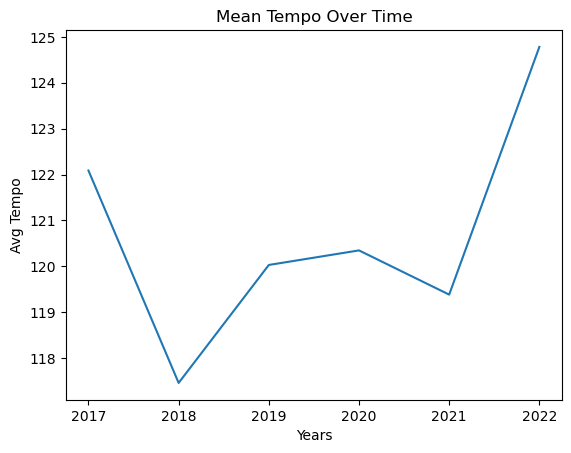

In [24]:
tempo_avg_x = tempo_df.index
tempo_avg_y = tempo_df["Mean Tempo"]
plt.plot(tempo_avg_x, tempo_avg_y)
plt.title("Mean Tempo Over Time")
plt.xlabel("Years")
plt.ylabel("Avg Tempo")
plt.savefig("output_data/avg_tempo.png")